<a href="https://colab.research.google.com/github/amhaiskar0921/AmazonProject/blob/main/Amazon_Project_Team_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
np.random.seed(42)

sample_size = 10000

shopping_data = pq.read_table('/content/drive/MyDrive/Amazon (LA) - Multi-Class Product Classification (Team A)/Datasets/shopping_queries_dataset_examples.parquet')
df = shopping_data.to_pandas().sample(n=sample_size, random_state=42)

In [5]:
df['query'].unique()


array(['100% cotton long sleeve t shirt women', 'mi full screen tv pro',
       'geocache', ..., 'asics', 'usb type c 充電スタンド',
       'nissan ns-2 cvt transmission fluid'], dtype=object)

In [6]:
df['product_locale'].unique()
# English, spanish, japanese search queries

array(['us', 'es', 'jp'], dtype=object)

In [21]:
df.head()
# Column names: example_id, query, query_id, product_id, product_locale,
# esci_label (I/E/S/C), small_version (bool), large_version (bool), split (test/train)

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
40527,40527,100% cotton long sleeve t shirt women,1450,B014WD3WOG,us,E,1,1,test
1351394,1351394,mi full screen tv pro,68591,B07Y25LMNP,es,I,1,1,train
895892,895892,geocache,44920,B014I55V8S,us,E,0,1,train
2454618,2454618,メンズ t シャツ バックプリント,124137,B086DHGYGF,jp,E,0,1,train
1302108,1302108,mary kay makeup remover eye,66054,B017PCGABI,us,S,1,1,train


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 40527 to 1454350
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   example_id      10000 non-null  int64 
 1   query           10000 non-null  object
 2   query_id        10000 non-null  int64 
 3   product_id      10000 non-null  object
 4   product_locale  10000 non-null  object
 5   esci_label      10000 non-null  object
 6   small_version   10000 non-null  int64 
 7   large_version   10000 non-null  int64 
 8   split           10000 non-null  object
dtypes: int64(4), object(5)
memory usage: 781.2+ KB


In [23]:
df.describe()

,example_id,query_id,small_version,large_version
count,1.000000e+04,10000.000000,10000.000000,10000.0
mean,1.309034e+06,66229.761200,0.429000,1.0
std,7.601128e+05,38995.965673,0.494958,0.0
min,1.550000e+02,5.000000,0.000000,1.0
25%,6.521602e+05,32372.250000,0.000000,1.0
50%,1.311720e+06,66533.500000,0.000000,1.0
75%,1.965694e+06,100601.000000,1.000000,1.0
max,2.620572e+06,130619.000000,1.000000,1.0


In [28]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)
print(f"number of products {len(pd.unique(df['product_id']))}")
print(f"total number of producs {len(df)}")

example_id        0
query             0
query_id          0
product_id        0
product_locale    0
esci_label        0
small_version     0
large_version     0
split             0
dtype: int64
number of products 1802772
total number of producs 2621288


In [12]:
# The data is already preprocessed, so there are no null values. The numeric columns (type int64) will not have outliers - they're just product and query IDs and 0/1 bools
# Now, we need to further study NLP (Hugging Face course) and PyTorch to create a model

In [13]:
# From project GitHub: https://github.com/amazon-science/esci-data/tree/main#filter-and-prepare-data-for-task-2
# DO NOT RUN YET
# df_task_2 = df_examples_products[df_examples_products["large_version"] == 1]
# df_task_2_train = df_task_2[df_task_2["split"] == "train"]
# df_task_2_test = df_task_2[df_task_2["split"] == "test"]

In [14]:
shopping_data_p = pq.read_table('/content/drive/MyDrive/Amazon (LA) - Multi-Class Product Classification (Team A)/Datasets/shopping_queries_dataset_products.parquet')
df_p = shopping_data_p.to_pandas().sample(n=sample_size, random_state=42)

In [ ]:
df_p.head()

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale
0,B079VKKJN7,"11 Degrees de los Hombres Playera con Logo, Ne...",Esta playera con el logo de la marca Carrier d...,11 Degrees Negro Playera con logo\nA estrenar ...,11 Degrees,Negro,es
1,B079Y9VRKS,Camiseta Eleven Degrees Core TS White (M),None,None,11 Degrees,Blanco,es
2,B07DP4LM9H,11 Degrees de los Hombres Core Pull Over Hoodi...,La sudadera con capucha Core Pull Over de 11 G...,11 Degrees Azul Core Pull Over Hoodie\nA estre...,11 Degrees,Azul,es
3,B07G37B9HP,11 Degrees Poli Panel Track Pant XL Black,None,None,11 Degrees,None,es
4,B07LCTGDHY,11 Degrees Gorra Trucker Negro OSFA (Talla úni...,None,None,11 Degrees,Negro (,es


missing values
product_id                 0
product_title              0
product_description     4747
product_bullet_point    1687
product_brand            786
product_color           3746
product_locale             0
dtype: int64
unique number of products 9998
total number of products 10000


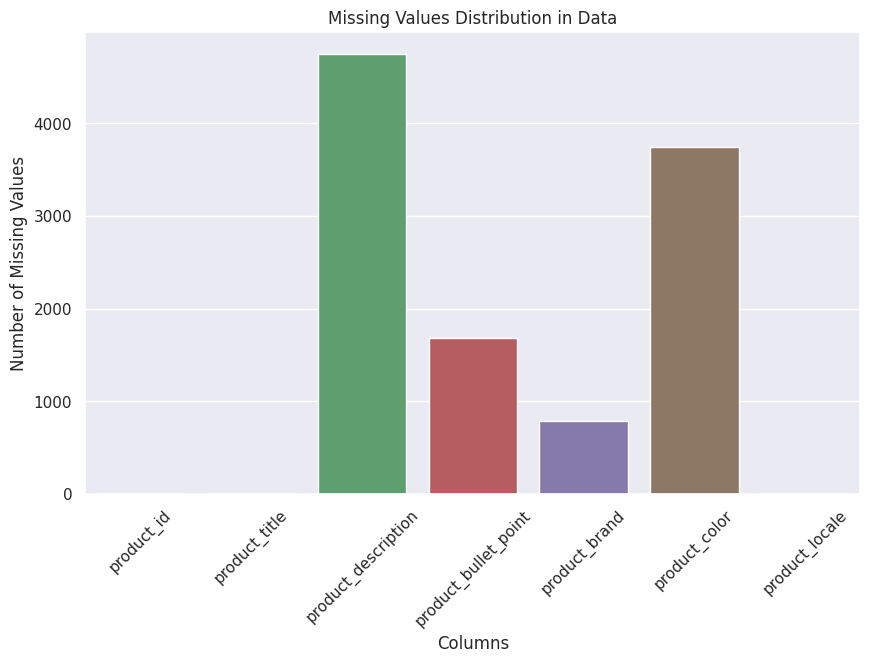

In [37]:
missing_values = df_p.isnull().sum()
print("missing values")
print(missing_values)
print(f"unique number of products {len(pd.unique(df_p['product_id']))}")
print(f"total number of products {len(df_p)}")
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=45)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values Distribution in Data')
plt.show()

In [39]:
df_merged = pd.merge(df, df_p, on='product_id', how='inner')
print(f"number of products {len(pd.unique(df_merged['product_id']))}")
df_merged_no_null = df_merged.fillna("")
missing_values = df_merged_no_null.isnull().sum()
print(missing_values)
df_p.size

number of products 9998
example_id              0
query                   0
query_id                0
product_id              0
product_locale_x        0
esci_label              0
small_version           0
large_version           0
split                   0
product_title           0
product_description     0
product_bullet_point    0
product_brand           0
product_color           0
product_locale_y        0
dtype: int64


70000

Text(0.5, 1.0, 'Frequency of Each ESCI Label')

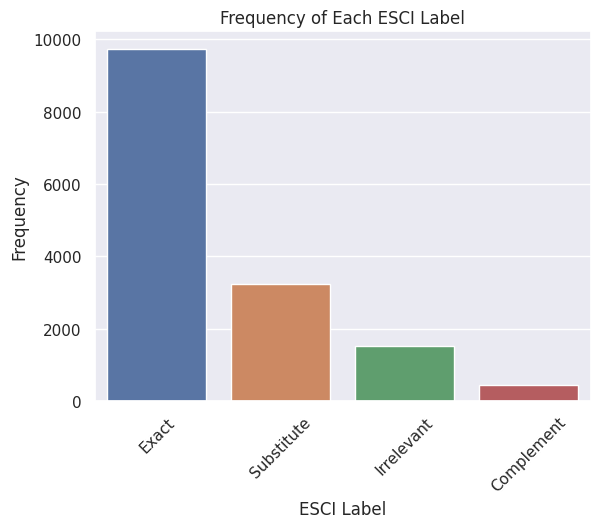

In [43]:
#plotting class imbalance
data = df_merged_no_null['esci_label'].value_counts()
sns.barplot(x=["Exact","Substitute","Irrelevant","Complement"], y=data.values)
plt.xticks(rotation=45)
plt.xlabel('ESCI Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each ESCI Label')

In [ ]:
df_merged_no_null[df_merged_no_null['product_id'] == 'B07RF1XD36']

,example_id,query,query_id,product_id,product_locale_x,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale_y
10853,2498,$150 laptop not previews,80,B07RF1XD36,us,E,1,1,test,Acer (エイサー) Aspire 5 スリム ノートパソコン 15.6インチ フルHD ...,9999,,SHINEZONE,,jp
10854,2498,$150 laptop not previews,80,B07RF1XD36,us,E,1,1,test,"Acer Aspire 5 Slim Laptop, 15.6 inches Full HD...",,AMD Ryzen 3 3200U Dual Core Processor (Up to 3...,Acer,Silver,us
10855,41076,100% off laptops,1468,B07RF1XD36,us,E,0,1,train,Acer (エイサー) Aspire 5 スリム ノートパソコン 15.6インチ フルHD ...,9999,,SHINEZONE,,jp
10856,41076,100% off laptops,1468,B07RF1XD36,us,E,0,1,train,"Acer Aspire 5 Slim Laptop, 15.6 inches Full HD...",,AMD Ryzen 3 3200U Dual Core Processor (Up to 3...,Acer,Silver,us
10857,57843,15 inch light weight laptop that has lots of m...,2162,B07RF1XD36,us,E,1,1,train,Acer (エイサー) Aspire 5 スリム ノートパソコン 15.6インチ フルHD ...,9999,,SHINEZONE,,jp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11072,2181678,windows laptop,111873,B07RF1XD36,us,E,0,1,train,"Acer Aspire 5 Slim Laptop, 15.6 inches Full HD...",,AMD Ryzen 3 3200U Dual Core Processor (Up to 3...,Acer,Silver,us
11073,2234932,y740 legion 15 inch gaming laptop,114673,B07RF1XD36,us,S,1,1,train,Acer (エイサー) Aspire 5 スリム ノートパソコン 15.6インチ フルHD ...,9999,,SHINEZONE,,jp
11074,2234932,y740 legion 15 inch gaming laptop,114673,B07RF1XD36,us,S,1,1,train,"Acer Aspire 5 Slim Laptop, 15.6 inches Full HD...",,AMD Ryzen 3 3200U Dual Core Processor (Up to 3...,Acer,Silver,us
11075,2254475,zephyrus gx501,115632,B07RF1XD36,us,S,0,1,test,Acer (エイサー) Aspire 5 スリム ノートパソコン 15.6インチ フルHD ...,9999,,SHINEZONE,,jp


In [ ]:
# concat dat
!pip install transformers
import torch
import transformers
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.5 MB/s eta 0:00:00


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased")

In [ ]:
df_merged['esci_label']

0          I
1          E
2          E
3          E
4          E
          ..
2680359    E
2680360    E
2680361    S
2680362    E
2680363    E
Name: esci_label, Length: 2680364, dtype: object

In [ ]:
# custom dataloader - don't need it right now
# issue: tokenize the strings first, move this to after tokens
# class CustomSet(Dataset):
#     def __init__(self, dataframe, X, y):
#         self.dataframe = dataframe
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, index):
#         a = self.dataframe[self.X].iloc[index]
#         b = self.dataframe[self.y].iloc[index]
#         # print("x y",x, y)
#         return a,b
#         # return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.long)

# label = "esci_label" #the esci label column
# features = [col for col in df_merged.columns if col != label]
# dataset = CustomSet(df_merged, features, label)
# custom_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# # for inputs, labels in custom_loader:
# #   print("moo")
# #   break
# for i, (inputs, labels) in enumerate(custom_loader):
#     print("Inputs shape:", len(inputs))
#     print("Labels shape:", len(labels))
#     break

In [ ]:
print(type(df_merged_no_null))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Add this code before tokenization
def remove_stopwords(text):
    stop_words_english = set(stopwords.words('english'))
    stop_words_spanish = set(stopwords.words('spanish'))
    # stop_words_japanese = set(stopwords.words('japanese')) <-- resulted in error
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_english
                      and word.lower() not in stop_words_spanish]
    return ' '.join(filtered_words)

In [ ]:
# Get a random sample of 10000 elems in the merged dataset with null values replaced
sample_size = 10000

# Initialize an empty list to store the modified input sequences
input_sequences = []

# Apply stopword removal to each element in the 'input_sequences' list using a for loop
for text in df_merged_no_null.apply(lambda x: f"[CLS] {x['product_title']} [SEP] {x['product_description']} [SEP] {x['product_bullet_point']} [SEP]", axis=1).tolist():
    cleaned_text = remove_stopwords(text)
    input_sequences.append(cleaned_text)


# print(input_sequences[:10])

In [ ]:
# input_sequences = sampled_merged_no_null.apply(lambda x: f"[CLS] {x['product_title']} [SEP] {x['product_description']} [SEP] {x['product_bullet_point']} [SEP]", axis=1).tolist()

In [ ]:
# print(df_merged_no_null)

In [ ]:
from transformers import BertTokenizer as tokenizer

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Example text to tokenize
# text = "This is an example sentence."

# Tokenize the text
tokens = tokenizer(input_sequences, padding=True, truncation=True, return_tensors="pt")

# Convert tokenized text to PyTorch tensors
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

In [ ]:
# input_data = tokenizer(sampled_merged_no_null, padding=True, truncation=True, return_tensors="pt", max_length=512)
# labels = torch.tensor(df["esci_label"].values.astype(int))


ValueError: ignored

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

In [ ]:
class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


In [ ]:
def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
      """Loads a data file into a list of `InputBatch`s."""

      input_items = []
      examples = zip(example_texts, example_labels)
      for (ex_index, (text, label)) in enumerate(examples):

          # Create a list of token ids
          input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
          if len(input_ids) > max_seq_length:
              input_ids = input_ids[:max_seq_length]

          # All our tokens are in the first input segment (id 0).
          segment_ids = [0] * len(input_ids)

          # The mask has 1 for real tokens and 0 for padding tokens. Only real
          # tokens are attended to.
          input_mask = [1] * len(input_ids)

          # Zero-pad up to the sequence length.
          padding = [0] * (max_seq_length - len(input_ids))
          input_ids += padding
          input_mask += padding
          segment_ids += padding

          assert len(input_ids) == max_seq_length
          assert len(input_mask) == max_seq_length
          assert len(segment_ids) == max_seq_length

          label_id = label2idx[label]

          input_items.append(
              BertInputItem(text=text,
                            input_ids=input_ids,
                            input_mask=input_mask,
                            segment_ids=segment_ids,
                            label_id=label_id))


      return input_items

In [ ]:
rest_texts, test_texts, rest_labels, test_labels = train_test_split(input_sequences, df_merged_no_null['esci_label'].tolist(), test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

In [ ]:
target_names = list(set(df_merged_no_null['esci_label'].tolist()))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'C': 0, 'I': 1, 'S': 2, 'E': 3}


In [ ]:
# inputItem = BertInputItem()
MAX_SEQ_LENGTH = 618 # No idea what this means :(
train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)